# 1 Neural Networks

This solution differs from what was asked for in the exercise in two ways:
1. The model has a hidden layer of dim=10 instead of 25 (can be easily changed)
2. The minimizetion algorithem I've been asked to use don't work (either by computation error or don't converge), so a simpel GD algorithem was implemented instead.

<b> both those changes are the result of my computer's fans screaming, as if they were been brutally stub to death<b/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
data = loadmat('../data/ex4data1.mat')
y = data['y']
y %= 10 # fixes “0” digit is labeled as “10”
y = np.squeeze(y) # shape [N,1] -> [N,]
X = data['X'] 
X = np.append(np.ones([X.shape[0],1]),X, axis=1) # add bais

In [3]:
m = X.shape[0]
inputDim = X.shape[1]
hiddenDim = 10
outputDim = 10

## 1.1 Visualizing the data

8


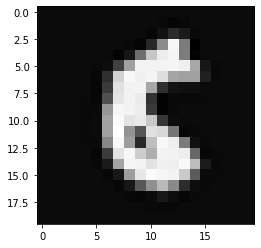

In [4]:
img_num = np.random.randint(len(y))
img = np.reshape(X[img_num, 1:], [20,20]).T
print(y[img_num])
plt.imshow(img, cmap='gray')
plt.show()

## 1.2 Model representation

In [5]:
weights = loadmat('../data/ex4weights.mat')
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
print(Theta1.shape)
print(Theta2.shape)

(25, 401)
(10, 26)


## 1.3 Feedforward and cost function

In [6]:
def sig(x):
    return 1/(1+np.exp(-x))

In [7]:
def FF(Theta1, Theta2, X):
#     input layer (X already has a colume of ones)
    a1 = X
#     Hidden layer
    z2 = X.dot(Theta1.T)
#     activation
    a2 = sig(z2)
#     add bais
    a2 = np.append(np.ones([a2.shape[0],1]),a2, axis=1)
#     output layer
    z3 = a2.dot(Theta2.T)
#     activation
    a3 = sig(z3)
    return a1, z2, a2, z3, a3

In [8]:
def labelM(y,K):
    """turns the labels to a one-hot matrix"""
#     change label to fit matlab 
#     y = (y.astype('int8') - 1) % 10 
    yM = np.zeros([len(y),K])
    yM[range(len(y)),y] = 1
    return yM

In [9]:
def roll(Theta1, Theta2):
    return np.append(Theta1,Theta2)

def unroll(thetaV, shape1, shape2):
    rows, cols = shape1
    Theta1 = np.reshape(thetaV[:(rows*cols)],shape1)
    Theta2 = np.reshape(thetaV[(rows*cols):],shape2)
    return Theta1, Theta2

In [10]:
def nnCostFunction(ThetaV,X,y, shape1, shape2, l = 0.0):
    Theta1, Theta2 = unroll(ThetaV, shape1, shape2)
    
    prob = FF(Theta1, Theta2,X) # (m,K)
    prob = prob[-1]
    yM = labelM(y,prob.shape[1]) # (m,K) 
    
#     NOTE: The following computation is the trace of a dot product, without explicitly computing the dot product.
#           hence it is much faster. it is equivallent to the following line: 
#     cost = np.trace(-yM.dot(np.log(prob).T)-(1-yM).dot(np.log(1-prob).T)) 

    cost = (-yM * np.log(prob) - (1-yM) * np.log(1-prob)).sum()
    cost /= len(y)

    reg = ((Theta1[:,1:]**2).sum() + (Theta2[:,1:]**2).sum())*(l/(2*len(y)))

    return cost+reg

# 2 Backpropagation

## 2.1 Sigmoid gradient

In [11]:
def sigGrad(x):
    g = sig(x)
    return g * (1 - g)

## 2.2 Random initialization

In [12]:
def randInitializeWeights(L_in, L_out):
    eps = np.sqrt(6)/np.sqrt(L_in+L_out)
    return np.random.rand(L_out,L_in)*2*eps-eps

## 2.3 Backpropagation

In [13]:
def computeGrad(ThetaV, X,y, shape1, shape2, l=0, print_loss = False):
    
    Theta1, Theta2 = unroll(ThetaV, shape1, shape2)
    yM = labelM(y,outputDim) # (m,outputDim)
    
    # Feedforward
    a1, z2, a2, z3, a3 = FF(Theta1, Theta2, X) # shapes: a1=(m, inputDim), z2=(m,hiddenDim), a2=(m,hiddenDim+1), z3=a3=(m,outputDim)
    
    # compute loss
    prob = a3
    cost = (-yM * np.log(prob) - (1-yM) * np.log(1-prob)).sum()
    cost /= len(y)

    reg = ((Theta1[:,1:]**2).sum() + (Theta2[:,1:]**2).sum())*(l/(2*len(y)))

    total_cost = cost+reg
        
    if print_loss:
        print(total_cost)
    
    # compute gradient
    
    d3 = a3-yM # (m, outputDim)
    D2 = d3.T.dot(a2) / m # (outputDim, hiddenDim+1)
    d2 = Theta2.T.dot(d3.T)[1:,:] * sigGrad(z2.T) # (hiddenDim, m)
    D1 = d2.dot(a1) / m # (hiddenDim, inputDim)

    # add regularization term

    D1[:,1:] += (l/m)*Theta1[:,1:]
    D2[:,1:] += (l/m)*Theta2[:,1:]
    
    return roll(D1, D2), total_cost

## 2.4 Gradient checking

In [16]:
test_Theta1 = randInitializeWeights(inputDim, hiddenDim) # (hiddenDim, inputDim)
test_Theta2 = randInitializeWeights(hiddenDim+1, outputDim) # (outputDim, hiddenDim+1)

shape1 = test_Theta1.shape
shape2 = test_Theta2.shape
test_ThetaV = roll(test_Theta1, test_Theta2)

cum_err = 0.0

eps = 1e-4
l=1.0

grad, loss = computeGrad(test_ThetaV, X,y, shape1, shape2, l)

for loc in range(len(test_ThetaV)):
    T_plus = test_ThetaV.copy()
    T_minus = test_ThetaV.copy()
    T_plus[loc] += eps 
    T_minus[loc] -= eps

    numeric_grad = (nnCostFunction(T_plus,X,y,shape1,shape2,l) - nnCostFunction(T_minus,X,y,shape1,shape2,l))/(2*eps)
    
    cum_err += np.abs((numeric_grad-grad[loc]))
    
print(cum_err)

4.127797708358598e-08


## 2.6 Learning parameters using fmincg

In [14]:
##### NOTE: this is what the exercise asks for, but it doesn't work. see next cell.

# init_Theta1 = randInitializeWeights(inputDim, hiddenDim) # (hiddenDim, inputDim)
# init_Theta2 = randInitializeWeights(hiddenDim+1, outputDim) # (outputDim, hiddenDim+1)

# shape1 = init_Theta1.shape
# shape2 = init_Theta2.shape
# init_ThetaV = roll(init_Theta1, init_Theta2)

# op_result = minimize(nnCostFunction, init_ThetaV, args=(X,y,shape1,shape2), method='TNC', jac=computeGrad)

##### NOTE: this is what the exercise asks for, but it doesn't work. see next cell.

In [18]:
def GD(init_ThetaV, X,y, shape1, shape2, l=0, iterations=10e3, alpha = 0.1, print_loss_every=100):
    ThetaV = init_ThetaV
    loss = np.zeros(iterations)
    for i in range(iterations):
        grad, loss[i] = computeGrad(ThetaV, X,y, shape1, shape2, l=0, print_loss = (i%print_loss_every)==0)
        ThetaV -=  alpha*grad
    return ThetaV, loss

8.716907631665123
1.5967108951538485
0.9963860095393869
0.7770253735603084
0.6709461261411424
0.6059885918318492
0.5602531444242166
0.5251573884706177
0.4966677287284582
0.4727256687181406
0.4522242607038257
0.4344409476543662
0.4188156368278569
0.4049202792485686
0.39243447724636804
0.381119250050993
0.3707942917892442
0.3613194684701341
0.35258077761973056
0.3444811681860115
0.3369356952187648
0.3298694814002283
0.32321709614232874
0.31692242113425445
0.3109384826756388
0.3052274303206915
0.29976095917556206
0.2945198054012958
0.2894906278172198
0.2846621226910007
0.2800233176511164
0.27556373777126364
0.27127374106613217
0.2671443771234918
0.2631669411998827
0.2593325348719391
0.25563182483007985
0.25205502987965284
0.24859209980784053
0.24523314917690023
0.24196941020665808
0.2387948628944031
0.23570743893065793
0.23270760941978028
0.22979536935578498
0.2269691393114445
0.2242264682888779
0.22156470310146234
0.21898118846478146
0.21647325955292923
0.21403821728534037
0.211673332456

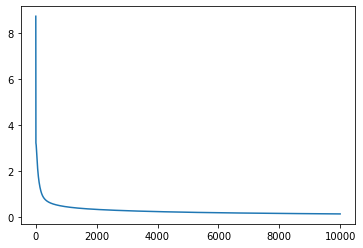

In [24]:
iterations = 10000 # must be int
alpha = 1
print_loss_every = 100

init_Theta1 = randInitializeWeights(inputDim, hiddenDim) # (hiddenDim, inputDim)
init_Theta2 = randInitializeWeights(hiddenDim+1, outputDim) # (outputDim, hiddenDim+1)

shape1 = init_Theta1.shape
shape2 = init_Theta2.shape

init_ThetaV = roll(init_Theta1, init_Theta2)


ThetaV ,loss = GD(init_ThetaV, X,y, shape1, shape2, iterations=iterations, alpha = alpha, print_loss_every=print_loss_every)

plt.plot(range(iterations), loss)

final_Theta1, final_Theta2 = unroll(ThetaV, shape1, shape2)
tup = FF(final_Theta1, final_Theta2, X)
prob = tup[-1]
pred = prob.argmax(axis=1)
acc = ((pred-y)==0).sum()/len(y)
print('The accuracy is: ' + str(acc))